# Sedona read raster data
In this seminar, we will use [sedona raster loader](https://sedona.apache.org/latest-snapshot/api/sql/Raster-loader/) to read various raster data formats:
- **GeoTIFF**: is a public domain metadata standard that allows `georeferencing` information to be embedded within a `TIFF` file.
- **NetCDF**: a file format for storing multidimensional scientific data (variables) such as temperature, humidity, pressure, wind speed, and direction. Each of these variables can be displayed through a dimension (such as time) in ArcGIS by making a layer or table view from the netCDF file.

> The potential additional information includes [map projection](https://en.wikipedia.org/wiki/Map_projection), [coordinate systems](https://en.wikipedia.org/wiki/Coordinate_system), [ellipsoids](https://en.wikipedia.org/wiki/Ellipsoid), [datums](https://en.wikipedia.org/wiki/Datum_(geodesy)), and everything else necessary to establish the exact spatial reference for the file.

## Source data

The `NetCDF` sample data(sea_surface_temperature_O1_2001-2002.nc) is from https://www.unidata.ucar.edu/software/netcdf/examples/files.html. It describes sea surface temperatures collected by `PCMDI` for use by the `IPCC`.


The `geotiff` sample data() is from https://www.planetobserver.com/geospatial-data-samples. It describes the global elevation of San Francisco USA.



In [ ]:
from urllib.parse import uses_relative

from sedona.spark import *
from pathlib import Path
import pyspark.sql.functions as f
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
from matplotlib import cm
import folium
import rasterio.features

In [ ]:
def open_and_visualize_geotiff(file_path):
    """
    Open and visualize a GeoTIFF file
    """
    # Open the raster file
    with rasterio.open(file_path) as src:
        # Read the data
        data = src.read(1)  # Read the first band

        # Get metadata
        print(f"Width: {src.width}, Height: {src.height}")
        print(f"Coordinate Reference System: {src.crs}")
        print(f"Bounds: {src.bounds}")

        # Create a figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plot the data using rasterio's show function
        image = show(src, ax=ax, title="GeoTIFF Visualization")

        # Add a colorbar
        cbar = plt.colorbar(image, ax=ax, shrink=0.6)
        cbar.set_label('Value')

        # Optional: Create a custom colormap for better visualization
        # Uncomment if you want to use a custom colormap
        """
        # Create a custom colormap
        colors = ['blue', 'green', 'yellow', 'red']
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

        # Plot with custom colormap
        image = show(src, ax=ax, cmap=cmap, title="GeoTIFF Visualization with Custom Colormap")
        cbar = plt.colorbar(image, ax=ax, shrink=0.6)
        cbar.set_label('Value')
        """

        plt.tight_layout()
        plt.show()

        return data, src.meta

In [ ]:
import io
import base64
def geotiff_to_folium(geotiff_path, output_html='geotiff_map.html', colormap='viridis', opacity=0.7):
    """
    Create an interactive Folium map from a GeoTIFF file

    Parameters:
    -----------
    geotiff_path : str
        Path to the GeoTIFF file
    output_html : str
        Path where the HTML map will be saved
    colormap : str
        Matplotlib colormap to use for the visualization
    opacity : float
        Opacity of the GeoTIFF overlay (0-1)

    Returns:
    --------
    str : Path to the saved HTML file
    """
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        # Get the center of the GeoTIFF
        bounds = src.bounds
        center_lon = (bounds.left + bounds.right) / 2
        center_lat = (bounds.bottom + bounds.top) / 2

        # Create a map centered on the GeoTIFF
        m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

        # Method 1: Export the visualization as a PNG image
        fig, ax = plt.subplots(figsize=(10, 10))
        rasterio.plot.show(src, ax=ax, cmap=colormap)
        ax.set_axis_off()

        # Save plot to a PNG image in memory
        img_data = io.BytesIO()
        plt.savefig(img_data, format='png', bbox_inches='tight', pad_inches=0)
        img_data.seek(0)
        plt.close()

        # Encode the image to base64 string
        encoded = base64.b64encode(img_data.read()).decode()

        # Add the image overlay to the map
        image_overlay = folium.raster_layers.ImageOverlay(
            image=f"data:image/png;base64,{encoded}",
            bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
            opacity=opacity,
            name='GeoTIFF Layer'
        )
        image_overlay.add_to(m)

        # Add basemap options
        folium.TileLayer('OpenStreetMap').add_to(m)

        # Add layer control and other UI elements
        folium.LayerControl().add_to(m)

        # Save the map
        m.save(output_html)

    return output_html



In [ ]:
# build a sedona session offline
project_root_dir = Path.cwd().parent.parent

print(project_root_dir.as_posix())

In [ ]:
sedona_version = "sedona-35-213-161"
jar_folder = Path(f"{project_root_dir}/jars/{sedona_version}")
jar_list = [str(jar) for jar in jar_folder.iterdir() if jar.is_file()]
jar_path = ",".join(jar_list)

# build a sedona session (sedona = 1.6.1) offline
config = SedonaContext.builder() \
    .master("local[*]") \
    .config('spark.jars', jar_path). \
    getOrCreate()

In [ ]:
# create a sedona context
sedona = SedonaContext.create(config)

#

In [ ]:
# get the spark context
sc = sedona.sparkContext

# use utf as default encoding
sc.setSystemProperty("sedona.global.charset", "utf8")

In [ ]:
data_dir = f"{project_root_dir}/data"
netcdf_sample = f"{data_dir}/netcdf/sea_surface_temperature_O1_2001-2002.nc"
geotiff_sample = f"{data_dir}/geotiff/PlanetDEM_3s_SanFrancisco.tif"

##  Read geo tiff sample data

In [ ]:
open_and_visualize_geotiff(geotiff_sample)


In [ ]:
# over match the geotiff with a map
geo_tiff_interactive_map = f"{data_dir}/tmp/geotiff_map.html"
geotiff_to_folium(geotiff_sample, output_html=geo_tiff_interactive_map)

In [ ]:
raw_geotiff = sedona.read.format("binaryFile").load(geotiff_sample)

raw_geotiff.show(5)

In [ ]:
raw_geotiff.createOrReplaceTempView("raw_geotiff")

In [ ]:
geotiff_df = raw_geotiff.withColumn("raster", f.expr("RS_FromGeoTiff(content)")).select("modificationTime","raster","content")
geotiff_df.show(10)

In [ ]:
geotiff_df.printSchema()

In [ ]:
print(type(geotiff_df))

In [ ]:
geotiff_df.select("raster").show(1, truncate=False)

In [ ]:
# can't write a geotiff dataframe into parquet

geotiff_parquet_out_path = f"{data_dir}/tmp/raster/geotiff"
geotiff_df.select("raster").write.mode("overwrite").parquet(geotiff_parquet_out_path)

## Read netcdf sample data

In [49]:
raw_netcdf = sedona.read.format("binaryFile").load(netcdf_sample)

In [50]:
raw_netcdf.show(5)

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/home/pliu/g...|2025-05-05 15:17:...|2949152|[43 44 46 01 00 0...|
+--------------------+--------------------+-------+--------------------+



In [ ]:
# we need to get the netcdf record info first

In [55]:
recordInfo = raw_netcdf.selectExpr("RS_NetCDFInfo(content) as record_info").first()[0]
print(recordInfo)


lon_bnds(lon=180, bnds=2)

lat_bnds(lat=170, bnds=2)

time_bnds(time=24, bnds=2)

tos(time=24, lat=170, lon=180)


In [56]:
netcdf_df = raw_netcdf.withColumn("raster", f.expr("RS_FromNetCDF(content, 'tos', 'lon', 'lat')")).select("modificationTime","raster","content")
netcdf_df.show(10)

+--------------------+--------------------+--------------------+
|    modificationTime|              raster|             content|
+--------------------+--------------------+--------------------+
|2025-05-05 15:17:...|GridCoverage2D["g...|[43 44 46 01 00 0...|
+--------------------+--------------------+--------------------+



In [57]:
netcdf_df.select("raster").show(1, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

There are many tools to read netcdf files in python. In below example, I use `xarray` and `netCDF4`

```shell
pip install xarray netCDF4
```

In [58]:
import xarray as xr

In [59]:
# Open the NetCDF file
ds = xr.open_dataset(netcdf_sample)

# Show dataset structure
print(ds)

<xarray.Dataset> Size: 3MB
Dimensions:    (lon: 180, bnds: 2, lat: 170, time: 24)
Coordinates:
  * lon        (lon) float64 1kB 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat        (lat) float64 1kB -79.5 -78.5 -77.5 -76.5 ... 86.5 87.5 88.5 89.5
  * time       (time) object 192B 2001-01-16 00:00:00 ... 2002-12-16 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (lon, bnds) float64 3kB ...
    lat_bnds   (lat, bnds) float64 3kB ...
    time_bnds  (time, bnds) object 384B ...
    tos        (time, lat, lon) float32 3MB ...
Attributes: (12/13)
    title:          IPSL  model output prepared for IPCC Fourth Assessment SR...
    institution:    IPSL (Institut Pierre Simon Laplace, Paris, France)
    source:         IPSL-CM4_v1 (2003) : atmosphere : LMDZ (IPSL-CM4_IPCC, 96...
    contact:        Sebastien Denvil, sebastien.denvil@ipsl.jussieu.fr
    project_id:     IPCC Fourth Assessment
    table_id:       Table O1 (13 November 2004)
    ...           

You can notice that it has four data variables:
- lon_bnds: (lon, bnds)
- lat_bnds: (lat, bnds)
- time_bnds: (time, bnds)
- tos: (time, lat, lon)

Now let's check the variable **tos**. The below code shows the details of variable `tos`

In [60]:
tos = ds["tos"]
print(tos)

<xarray.DataArray 'tos' (time: 24, lat: 170, lon: 180)> Size: 3MB
[734400 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 1kB 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat      (lat) float64 1kB -79.5 -78.5 -77.5 -76.5 ... 86.5 87.5 88.5 89.5
  * time     (time) object 192B 2001-01-16 00:00:00 ... 2002-12-16 00:00:00
Attributes:
    standard_name:   sea_surface_temperature
    long_name:       Sea Surface Temperature
    units:           K
    cell_methods:    time: mean (interval: 30 minutes)
    original_name:   sosstsst
    original_units:  degC
    history:          At   16:37:23 on 01/11/2005: CMOR altered the data in t...


Let's visualize the data in a figure, you can notice, it uses the default projection in the file.

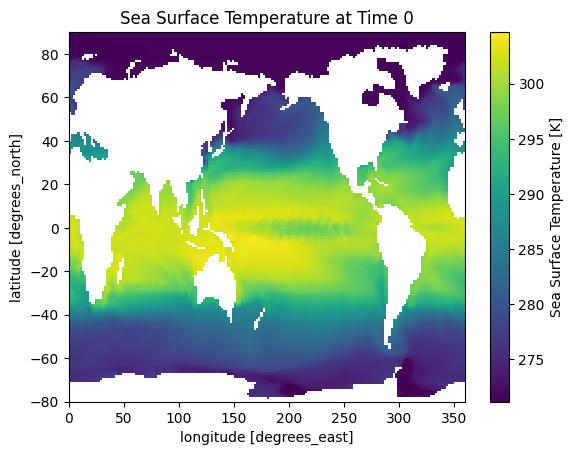

In [61]:
# Plot a 2D slice (e.g., first time step)
tos.isel(time=0).plot()  # Use correct dimension names like lat/lon
plt.title("Sea Surface Temperature at Time 0")
plt.show()

If you want to change the projection system, you need to use package `cartopy`

```shell
pip install cartopy
```

/home/pliu/git/ConstanceDataPlatform/cdp_venv/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


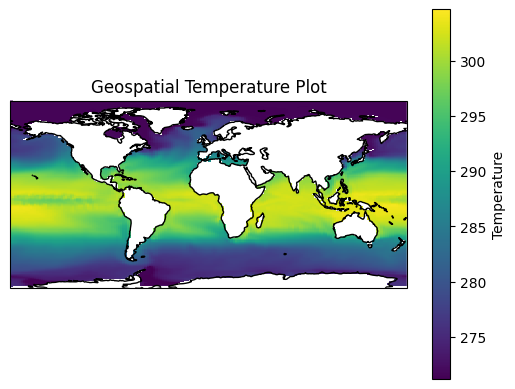

In [62]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
tos.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Temperature'})
ax.coastlines()
plt.title("Geospatial Temperature Plot")
plt.show()